# Fundamentals of Machine Learning - Exercise 5

Johannes Kammerer, Zhao Sun, Tong Yu

### 3 Constructing the matrix X (25 points)

In [1]:
# import
import numpy as np
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import lsqr
import matplotlib.pyplot as plt

In [2]:
# construct matrix
def construct_X(M, alphas, Np = None):
    '''
    Constructs sparse matrix X
    M: object dimension D=MxM
    alphas: list of angles
    Np: # sensor pixels
    '''
    if Np == None:
        Np = (np.ceil(np.sqrt(2)*M)//2 * 2 + 1).astype(int) # rounds up to next odd integer
    #assert Np-1 >= np.sqrt(2)*(M-1) # for projection
    D = M**2
    N = len(alphas)*Np
    weights = []
    i_indices = []
    j_indices = []
    for io in range(len(alphas)):
        a = np.deg2rad(alphas[io])
        jb, ja = np.mgrid[0:M, 0:M]
        ja = ja.flatten()
        jb = jb.flatten()
        a0, b0 = -(M-1)/2, -(M-1)/2
        C0 = a0 + ja
        C1 = b0 + jb
        C = np.column_stack((C0, C1)).T
        n = np.column_stack((np.cos(a), -np.sin(a)))
        s0 = (Np-1)/2
        p = n@C + s0
        plow = np.floor(p)
        phigh = plow + 1
        Xlow = phigh-p
        Xhigh = p-plow
        weights = np.concatenate((weights, Xlow, Xhigh), axis=None)
        i_indices = np.concatenate((i_indices, plow + Np*io, phigh + Np*io), axis=None)
        j_indices = np.concatenate((j_indices, np.arange(D), np.arange(D)), axis=None)
     
    X = coo_matrix((weights, (i_indices, j_indices)), shape = (N, D), dtype = np.float32)
    return X

<span style ="color: green; font-weight: bold;  "> COMMENTS: Essentially same as the quicker method "construct_X" of the solution provided. </span>

In [3]:
X = construct_X(M = 10, alphas = [-33, 1, 42])
Xar = X.toarray()

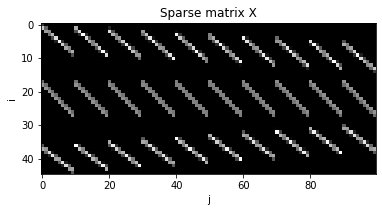

In [4]:
plt.imshow(Xar, cmap="gray")
plt.title('Sparse matrix X')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

In [5]:
# Numerical check:
X_ex = np.load('hs_tomography/X_example.npy')
np.where(X_ex-Xar != 0)

(array([], dtype=int64), array([], dtype=int64))

<span style="font-weight: bold">Observation: Our matrix is identical to the matrix X_example.</span>

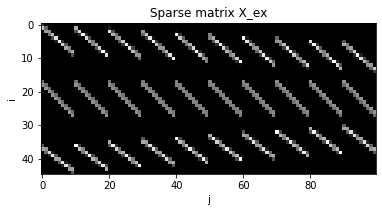

In [6]:
# Visual check:
plt.imshow(X_ex, cmap="gray")
plt.title('Sparse matrix X_ex')
plt.xlabel('j')
plt.ylabel('i')
plt.show()

<span style="font-weight: bold">Observation: They agree both numerically and visually.</span>

<span style ="color: green; font-weight: bold;  "> COMMENTS: Got the same result as the soultion. </span>

### 4 Recovering the image (6 points)

#### M=77

In [7]:
# load data
alphas_77 = np.load('hs_tomography/alphas_77.npy')
y_77 = np.load('hs_tomography/y_77.npy')

In [8]:
# construct sparse matrix in COO and CSC format
COO_77 = construct_X(M = 77, alphas = alphas_77, Np = 109)
CSC_77 = COO_77.tocsc()

In [9]:
# Sparsity
nz = csr_matrix.count_nonzero(COO_77)
el = np.prod(COO_77.shape)
print('Nonzero entries of X: ', nz)
print('Shape of X: ', COO_77.shape)
print('Sparsity of X: ', np.around(nz/el, 5))

Nonzero entries of X:  1066978
Shape of X:  (9810, 5929)
Sparsity of X:  0.01834


<span style ="color: green; font-weight: bold;  "> COMMENTS: A small error with "Sparsity of X", our result is matrix density rather than sparsity. It should be subtracted from '1', which will be in line with the provided solution.</span>

In [10]:
beta_77 = lsqr(CSC_77, y_77)[0]

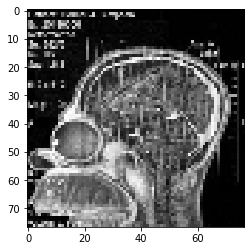

In [11]:
plt.imshow(beta_77.reshape((77, 77)), cmap="gray")
plt.show()

<span style ="color: green; font-weight: bold;  "> COMMENTS: Bacially same with the solution. We could also measure our experiment running time to test the code efficiency.</span>

#### M=195

In [12]:
# load data
alphas_195 = np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')

In [13]:
# construct sparse matrix in COO and CSC format
COO_195 = construct_X(M = 195, alphas = alphas_195, Np = 275)
CSC_195 = COO_195.tocsc()

In [14]:
# Sparsity
nz = csr_matrix.count_nonzero(COO_195)
el = np.prod(COO_195.shape)
print('Nonzero entries of X: ', nz)
print('Shape of X: ', COO_195.shape)
print('Sparsity of X: ', np.around(nz/el, 5))

Nonzero entries of X:  13535953
Shape of X:  (49225, 38025)
Sparsity of X:  0.00723


<span style ="color: green; font-weight: bold;  "> COMMENTS: Same error as above. "Sparsity of X", should be matrix sparsity, ours is matrix density.</span>

In [15]:
beta_195 = lsqr(CSC_195, y_195, atol=1e-06, btol=1e-06)[0]

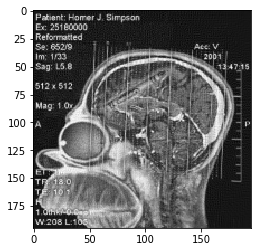

In [16]:
plt.imshow(beta_195.reshape((195, 195)), cmap="gray")
plt.show()

<span style="font-weight: bold">Diagnose: Homer caught some bullet in his head. ;( \
    Treatment: Remove the bullet! ;)</span>

<span style ="color: green; font-weight: bold;  "> COMMENTS: Our solution is line with the given solution.</span>

### 5 Minimizing the radiation dose (9 points)

#### Method 1: randomly select angles

In [17]:
No = 179
Np = 275
M = 195

In [18]:
sol = []
dose = np.arange(0.1, 0.9, 0.1)
for d in dose:
    pos = np.arange(No*Np).reshape((No,Np))
    ios = np.sort(np.random.choice(No, np.int(d*No), replace = False))
    pos = pos[ios,:].flatten()
    y = y_195[pos]
    CSC = CSC_195[pos,:]
    b = lsqr(CSC, y, atol=1e-05, btol=1e-05)[0]
    sol.append(b)

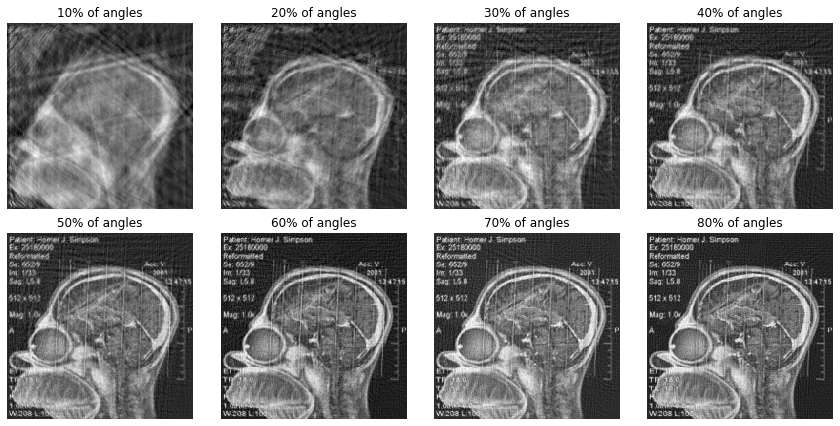

In [19]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)
for i in range(len(dose)):
    axes[i//4,i%4].imshow(sol[i].reshape((M,M)), cmap="gray")
    axes[i//4,i%4].set_axis_off()
    axes[i//4,i%4].set_title('%.i%% of angles' %(100*dose[i]))
plt.show()

#### Method 2: Every n-th projection angle

In [20]:
soln = []
dosefactor = [5, 4, 3, 2]
for d in dosefactor:
    pos = np.arange(No*Np).reshape((No,Np))
    ios = np.arange(0, No, d)
    pos = pos[ios,:].flatten()
    y = y_195[pos]
    CSC = CSC_195[pos,:]
    b = lsqr(CSC, y, atol=1e-05, btol=1e-05)[0]
    soln.append(b)

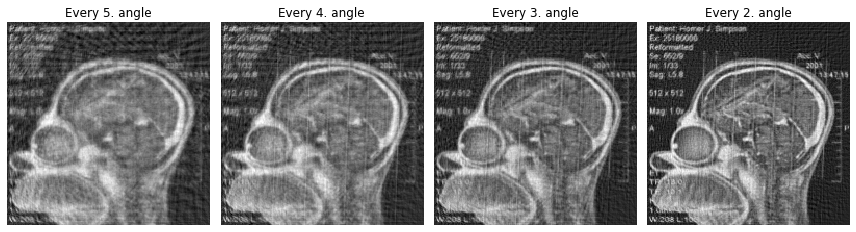

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), tight_layout=True)
for i in range(4):
    axes[i].imshow(soln[i].reshape((M,M)), cmap="gray")
    axes[i].set_axis_off()
    axes[i].set_title('Every %.i. angle' %dosefactor[i])
plt.show()

<span style="font-weight: bold">Observation: \
    Summarizing the experience from the two methods, we need around 30% of the dose (circa 60 projection angles) to resolve the bullet. \
    Method 1 randomly selects a certain percentage of the measured projection angles.  Method 2 uses every n-th projection. It is therefore closer oriented towards an actual implementation because the dose would typically be reduced by using a coarser resolution of projection angles. Both methods function well.</span>

<span style ="color: green; font-weight: bold;  "> COMMENTS: we not only pick the angles specifically like the given solution does, but also pick them randomly. And our conclusion is "circa 60 angles" is the optimal number of angles, which is in line with the given solution "with 64  projections it is quite clear".
</span>